**Please note that the 01_setup notebook should be executed before running this notebook**

In [1]:
import os, textwrap
from icecream import ic
# Get original notebook path and LD_LIBRARY_PATH
notebook_path = ic(os.getcwd())
original_ld_library_path = ic(os.environ.get('LD_LIBRARY_PATH'))
# Software and install_prefix as defined in 01_setup.ipynb
software_path = ic(os.path.join(notebook_path, 'sjk012', 'software'))
install_prefix = ic(os.path.join(software_path, 'opt'))

ic| Error: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a 

frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?
ic| Error: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?
ic| Error: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?
ic| Error: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?


In [2]:
# Update the environment
os.environ['LD_LIBRARY_PATH'] = os.path.join(install_prefix, 'blis', 'lib')
os.environ['LD_LIBRARY_PATH'] += ":"
os.environ['LD_LIBRARY_PATH'] += os.path.join(install_prefix, 'openblas', 'lib')
if original_ld_library_path is not None:
    os.environ['LD_LIBRARY_PATH'] += ":"
    os.environ['LD_LIBRARY_PATH'] += original_ld_library_path
_ = ic(os.environ['LD_LIBRARY_PATH'])

ic| Error: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?


In [3]:
# Setup cell
import numpy as np
import matplotlib.pyplot as plt
from sjk012.classifiers.cnn import *
from sjk012.data_utils import get_CIFAR10_data
from sjk012.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from sjk012.layers import *
# from sjk012.fast_layers import *
from sjk012.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Use pyximport to compile the cython modules
import pyximport
pyximport.install(reload_support=True, pyimport=True)

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [4]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


# Convolutional "Sandwich" Layers
In the previous assignment, we introduced the concept of "sandwich" layers that combine multiple operations into commonly used patterns. In the file `sjk012/layer_utils.py` you will find sandwich layers that implement a few commonly used patterns for convolutional networks. Run the cells below to sanity check their usage.

In [5]:
from sjk012.layer_utils import conv_relu_pool_forward, conv_relu_pool_backward
from sjk012.gradient_check import *
np.random.seed(12)
x = np.random.randn(2, 3, 8, 8).astype(np.float32)
w = np.random.randn(3, 3, 3, 3).astype(np.float32)
b = np.random.randn(3,).astype(np.float32)
dy = np.random.randn(2, 3, 4, 4).astype(np.float32)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2, 'padding': 0}

y, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dy, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dy, h=1e-3)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dy, h=1e-3)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dy, h=1e-3)

# Relative errors should be around e-8 or less
print('Testing conv_relu_pool')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu_pool
dx error:  0.025724232
dw error:  0.0016250116
db error:  2.2331476e-05


In [6]:
import numpy as np

# Define a simple input, filter, and upstream gradient
x = np.array([[[[1, 2, 3],
                [4, 5, 6],
                [7, 8, 9]]]], dtype=np.float32)
w = np.array([[[[1, 2],
                [3, 4]]]], dtype=np.float32)
b = np.array([0], dtype=np.float32)
conv_param = {'stride': 1, 'pad': 0}
dout = np.array([[[[10, 10],
                   [10, 10]]]], dtype=np.float32)

# Call the conv_forward_cython and conv_backward_cython functions
out, cache = conv_forward_cython(x, w, b, conv_param)
dx, dw, db = conv_backward_cython(dout, cache)

# Manually calculate the expected gradients
expected_dx = np.array([[[[10, 20, 10],
                          [30, 60, 30],
                          [20, 40, 20]]]], dtype=np.float32)
expected_dw = np.array([[[[150, 200],
                          [350, 400]]]], dtype=np.float32)
expected_db = np.array([40], dtype=np.float32)

# Check if the actual gradients match the expected gradients
print('Testing conv_backward_cython function:')
print('dx error: ', rel_error(expected_dx, dx))
print('dw error: ', rel_error(expected_dw, dw))
print('db error: ', rel_error(expected_db, db))

Testing conv_backward_cython function:
dx error:  0.33333334
dw error:  0.18644068
db error:  0.0


# Three-Layer Convolutional Network
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Open the file `sjk012/classifiers/cnn.py` and complete the implementation of the `ThreeLayerConvNet` class. Remember you can use the fast/sandwich layers (already imported for you) in your implementation. Run the following cells to help you debug:

## Sanity Check Loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization the loss should go up slightly.

In [7]:
model = ThreeLayerConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32).astype(np.float32)
y = np.random.randint(10, size=N).astype(np.int8)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.3025859069824217
Initial loss (with regularization):  2.5087668669223784


## Gradient Check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artificial data and a small number of neurons at each layer. Note: correct implementations may still have relative errors up to the order of e-2.

In [8]:
num_inputs = 2
input_dim = (3, 8, 8)
reg = 0.0
num_classes = 10
np.random.seed(12)
X = np.random.randn(num_inputs, *input_dim).astype(np.float32)
y = np.random.randint(num_classes, size=num_inputs).astype(np.int8)

model = ThreeLayerConvNet(
    num_filters=3,
    filter_size=3,
    input_dim=input_dim,
    hidden_dim=5,
    dtype=np.float32
)
loss, grads = model.loss(X, y)
# Errors should be small, but correct implementations may have
# relative errors up to the order of e-2
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-0)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])), 'Allclose: ', np.allclose(param_grad_num, grads[param_name], atol=1e-2))

W1 max relative error: 1.000000e+00 Allclose:  True
W2 max relative error: 1.000000e+00 Allclose:  True
W3 max relative error: 1.862459e-01 Allclose:  True
b1 max relative error: 1.000000e+00 Allclose:  True
b2 max relative error: 1.000000e+00 Allclose:  True
b3 max relative error: 5.630022e-02 Allclose:  False


## Overfit Small Data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [9]:
np.random.seed(12)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train].astype(np.float32),
  'y_train': data['y_train'][:num_train].astype(np.int8),
  'X_val': data['X_val'].astype(np.float32),
  'y_val': data['y_val'].astype(np.int8),
}

model = ThreeLayerConvNet(dtype=np.float32)

solver = Solver(
    model,
    small_data,
    num_epochs=20,
    batch_size=50,
    update_rule='adam',
    optim_config={'learning_rate': 1e-3,},
    verbose=True,
    print_every=1
)
solver.train()

(Iteration 1 / 40) loss: 2.302594
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.119000
(Iteration 2 / 40) loss: 2.280381
(Epoch 1 / 20) train acc: 0.240000; val_acc: 0.135000
(Iteration 3 / 40) loss: 2.260540
(Iteration 4 / 40) loss: 2.174955
(Epoch 2 / 20) train acc: 0.330000; val_acc: 0.151000
(Iteration 5 / 40) loss: 1.965284
(Iteration 6 / 40) loss: 2.281384
(Epoch 3 / 20) train acc: 0.230000; val_acc: 0.149000
(Iteration 7 / 40) loss: 2.000278
(Iteration 8 / 40) loss: 1.973748
(Epoch 4 / 20) train acc: 0.300000; val_acc: 0.161000
(Iteration 9 / 40) loss: 1.909458
(Iteration 10 / 40) loss: 1.773626
(Epoch 5 / 20) train acc: 0.340000; val_acc: 0.166000
(Iteration 11 / 40) loss: 1.633246
(Iteration 12 / 40) loss: 1.625742
(Epoch 6 / 20) train acc: 0.410000; val_acc: 0.183000
(Iteration 13 / 40) loss: 1.370308
(Iteration 14 / 40) loss: 1.695501
(Epoch 7 / 20) train acc: 0.500000; val_acc: 0.172000
(Iteration 15 / 40) loss: 1.235599
(Iteration 16 / 40) loss: 1.488163
(Epoch 8 / 20) tr

In [10]:
# Print final training accuracy.
print(
    "Small data training accuracy:",
    solver.check_accuracy(small_data['X_train'], small_data['y_train'])
)

Small data training accuracy: 0.9


In [11]:
# Print final validation accuracy.
print(
    "Small data validation accuracy:",
    solver.check_accuracy(small_data['X_val'], small_data['y_val'])
)

Small data validation accuracy: 0.214


Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

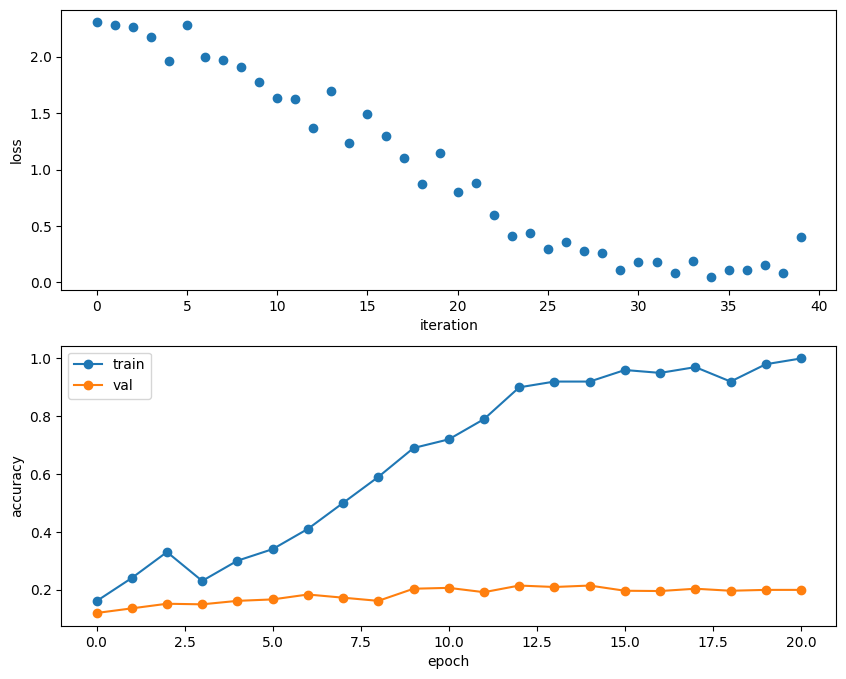

In [12]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Parallel Performance Evaluation: Analyzing Training Time with Different Number of Threads and Batch Sizes

In this exercise, you will explore how the training time of a convolutional neural network (CNN) model varies with different numbers of threads and batch sizes. You will use the provided training code to train the model and measure the training time for various configurations.

### Instructions:

1. Load the provided dataset (`data`) and ensure it contains the necessary training and validation data.
2. Implement the `train_model` function to train the CNN model using the specified number of threads and batch size. Use the provided training code as a reference.
3. Set the right batch size to the solver (`batch_size`) to test.
4. Measure the training time of the `train_model` function.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import time
from threadpoolctl import threadpool_limits

# Define the training code
def train_model(batch_size):
    np.random.seed(12)

    ###########################################################################
    # TODO: Call the train model method and measure its training time         #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    model = ThreeLayerConvNet(dtype=np.float32)

    solver = Solver(
        model,
        small_data,
        num_epochs=20,
        batch_size=batch_size,
        update_rule='adam',
        optim_config={'learning_rate': 1e-3,},
        verbose=True,
        print_every=1
    )
    
    start_time = time.time()
    solver.train()
    end_time = time.time()
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################    
    
    return end_time - start_time

# Define the number of threads and batch size configurations to test
num_threads_list = [1, 4, 8, 16]
batch_size_list = [16, 32, 64]

# Measure the training time for each configuration
training_times = np.zeros((len(num_threads_list), len(batch_size_list)))

for i, n_threads in enumerate(num_threads_list):
    with threadpool_limits(limits=n_threads):
        for j, batch_size in enumerate(batch_size_list):
            print('Testing training with %d threads and %d batch size' %(n_threads, batch_size))
            training_time = train_model(batch_size)
            training_times[i, j] = training_time

Testing training with 1 threads and 16 batch size
(Iteration 1 / 120) loss: 2.302579
(Epoch 0 / 20) train acc: 0.060000; val_acc: 0.087000
(Iteration 2 / 120) loss: 2.398489
(Iteration 3 / 120) loss: 2.311533
(Iteration 4 / 120) loss: 2.244668
(Iteration 5 / 120) loss: 2.209500
(Iteration 6 / 120) loss: 2.346014
(Epoch 1 / 20) train acc: 0.170000; val_acc: 0.132000
(Iteration 7 / 120) loss: 2.132515
(Iteration 8 / 120) loss: 2.377617
(Iteration 9 / 120) loss: 2.380939
(Iteration 10 / 120) loss: 2.257062
(Iteration 11 / 120) loss: 2.280143
(Iteration 12 / 120) loss: 2.374243
(Epoch 2 / 20) train acc: 0.120000; val_acc: 0.100000
(Iteration 13 / 120) loss: 2.261115
(Iteration 14 / 120) loss: 2.268343
(Iteration 15 / 120) loss: 2.200629
(Iteration 16 / 120) loss: 2.343858
(Iteration 17 / 120) loss: 2.060696
(Iteration 18 / 120) loss: 2.295085
(Epoch 3 / 20) train acc: 0.240000; val_acc: 0.144000
(Iteration 19 / 120) loss: 2.122414
(Iteration 20 / 120) loss: 1.853971
(Iteration 21 / 120) lo

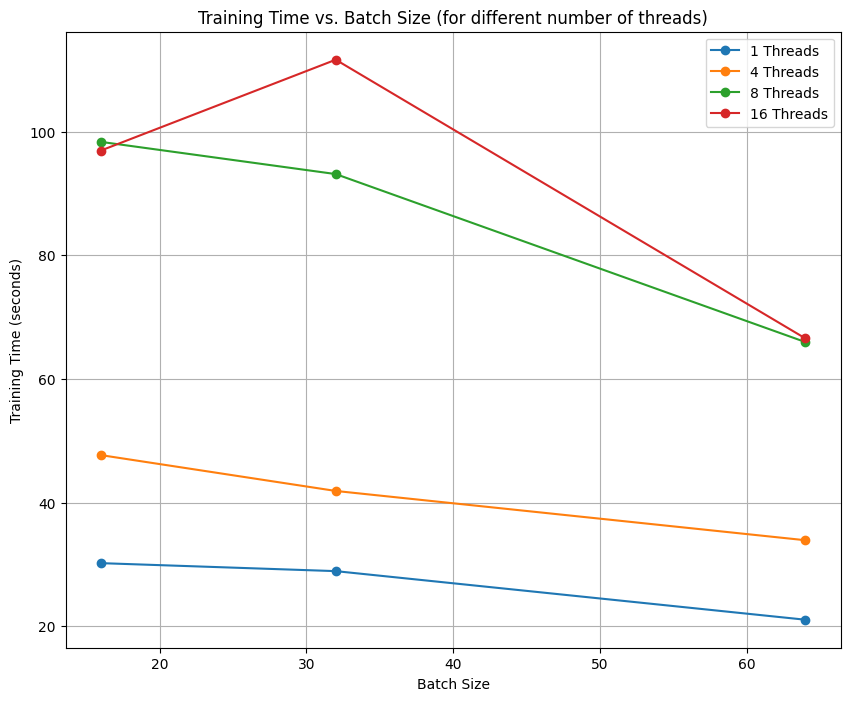

In [14]:
# Plot the training time for each batch size, with different lines for each number of threads
plt.figure()
for i, num_threads in enumerate(num_threads_list):
    plt.plot(batch_size_list, training_times[i, :], marker='o', label=f'{num_threads} Threads')

plt.xlabel('Batch Size')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time vs. Batch Size (for different number of threads)')
plt.legend()
plt.grid(True)
plt.show()

## Train the Network
By training the three-layer convolutional network for one epoch, you should achieve greater than 40% accuracy on the training set:

In [15]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

all_data = {
   'X_train': data['X_train'].astype(np.float32),
   'y_train': data['y_train'].astype(np.int8),
   'X_val': data['X_val'].astype(np.float32),
   'y_val': data['y_val'].astype(np.int8),
}

solver = Solver(
    model,
    all_data,
    num_epochs=1,
    batch_size=50,
    update_rule='adam',
    optim_config={'learning_rate': 1e-3,},
    verbose=True,
    print_every=20
)
solver.train()

(Iteration 1 / 980) loss: 2.304592
(Epoch 0 / 1) train acc: 0.113000; val_acc: 0.119000
(Iteration 21 / 980) loss: 2.085582
(Iteration 41 / 980) loss: 1.996592
(Iteration 61 / 980) loss: 1.792028


(Iteration 81 / 980) loss: 1.718244
(Iteration 101 / 980) loss: 2.145690
(Iteration 121 / 980) loss: 1.422840
(Iteration 141 / 980) loss: 1.803378
(Iteration 161 / 980) loss: 2.003324
(Iteration 181 / 980) loss: 1.536438
(Iteration 201 / 980) loss: 1.887214
(Iteration 221 / 980) loss: 1.872427
(Iteration 241 / 980) loss: 1.641956
(Iteration 261 / 980) loss: 1.861832
(Iteration 281 / 980) loss: 1.646468
(Iteration 301 / 980) loss: 1.597706
(Iteration 321 / 980) loss: 1.399799
(Iteration 341 / 980) loss: 1.532237
(Iteration 361 / 980) loss: 1.793809
(Iteration 381 / 980) loss: 1.763346
(Iteration 401 / 980) loss: 1.362340
(Iteration 421 / 980) loss: 1.466926
(Iteration 441 / 980) loss: 1.531760
(Iteration 461 / 980) loss: 2.052624
(Iteration 481 / 980) loss: 1.552522
(Iteration 501 / 980) loss: 1.629435
(Iteration 521 / 980) loss: 1.615437
(Iteration 541 / 980) loss: 1.324812
(Iteration 561 / 980) loss: 1.504487
(Iteration 581 / 980) loss: 1.569043
(Iteration 601 / 980) loss: 1.446921
(I

In [16]:
# Print final training accuracy.
print(
    "Full data training accuracy:",
    solver.check_accuracy(data['X_train'].astype(np.float32), data['y_train'])
)

Full data training accuracy: 0.4642040816326531


In [17]:
# Print final validation accuracy.
print(
    "Full data validation accuracy:",
    solver.check_accuracy(data['X_val'].astype(np.float32), data['y_val'])
)

Full data validation accuracy: 0.465


## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

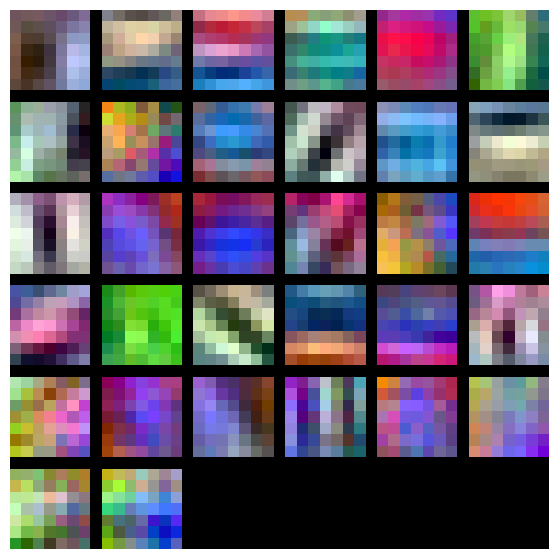

In [18]:
from sjk012.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(7,7)
plt.show()